In [1]:
import pandas as pd

# shot_list_sheet_1 = pd.read_excel("./dataset/KSTAR_Disruption_Shot_List.csv", sheet_name = 'Sheet1')
# shot_list_sheet_2 = pd.read_excel("./dataset/KSTAR_Disruption_Shot_List.csv", sheet_name = 'Sheet2')
short_list_sheet = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List.csv")

In [2]:
short_list_sheet

,shot,year,tftsrt,tipminf,tTQend,Isdata
0,12350,2015,1.500,5.246,5.2248,NaN
1,12372,2015,0.700,3.818,3.8026,NaN
2,12415,2015,1.900,4.769,4.7450,NaN
3,12438,2015,1.100,3.702,3.6826,NaN
4,12481,2015,1.900,5.217,5.1923,NaN
...,...,...,...,...,...,...
1091,21730,2018,1.500,4.968,4.9490,NaN
1092,21731,2018,1.500,4.913,4.8950,NaN
1093,21735,2018,1.500,89.746,89.7320,NaN
1094,21747,2018,3.724,11.451,11.4190,NaN


In [3]:

from src.dataloader import VideoDataset
from torch.utils.data import DataLoader

batch_size = 4
train_data_dist10 = VideoDataset(dataset = "fast_model_dataset", split = "train", clip_len = 8, preprocess = False)
train_loader_dist10 = DataLoader(train_data_dist10, batch_size = batch_size, shuffle = True, num_workers = 4)


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of train videos: 1240


sample_img :  torch.Size([3, 112, 112])


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


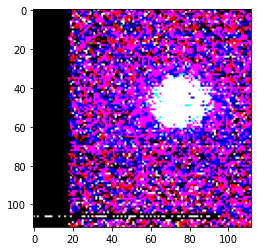

In [4]:
sample_data, sample_label = next(iter(train_loader_dist10))
sample_img = sample_data[0, :, 0, :, :]

print("sample_img : ", sample_img.size())

from src.utility import show_frame

show_frame(sample_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


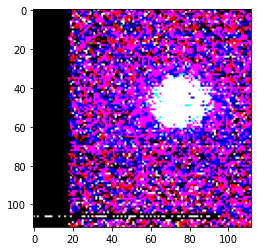

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


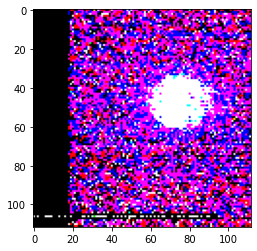

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


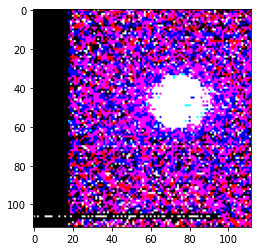

In [5]:
for idx in range(sample_data.size(1)):
    sample_img = sample_data[0, :, idx, :, :]
    show_frame(sample_img)

In [6]:
sample_data, sample_target = next(iter(train_loader_dist10))
print("sample data : ", sample_data.size())
print("sample target : ", sample_target.size())

sample data :  torch.Size([4, 3, 8, 112, 112])
sample target :  torch.Size([4])


In [7]:
from src.model import VideoSpatioEncoder

encoder = VideoSpatioEncoder(
    input_shape  = (3, 8, 112, 112),
    STN_conv_channels  = [3, 16, 32], 
    STN_conv_kernels  = [8, 4],
    STN_conv_strides  = [1, 1],
    STN_conv_paddings  = [0, 0],
    STN_pool_strides  =  [2, 2],
    STN_pool_kernels  = [2, 2],
    alpha  = 0.01,
    STN_theta_dim = 64
)

In [8]:
sample_enc = encoder(sample_data)
print("sample_enc : ", sample_enc.size())

sample_enc :  torch.Size([4, 8, 18432])


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [9]:
from src.transformer import SBERT
sbert = SBERT(
    num_features = sample_enc.size(-1),
    hidden = 128,
    n_layers = 4,
    attn_heads = 8, 
    max_len  = 8
)

In [10]:
import torch

sample_doy = torch.tensor([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
sample_mask = None

sample_sbert_output = sbert(sample_enc, sample_doy, sample_mask)

In [11]:
print("sbert output : ", sample_sbert_output.size())

sbert output :  torch.Size([4, 8, 128])


In [12]:
sample_doy = torch.IntTensor(list(map(int, range(1, 8 + 1)))).repeat(sample_enc.size(0), 1)
sample_mask = None
sample_sbert_output = sbert(sample_enc, sample_doy, sample_mask)
print("sbert output : ", sample_sbert_output.size())

sbert output :  torch.Size([4, 8, 128])


In [13]:
seq_len = 8
doy_dims = seq_len
num_features = 18432

sample_x = torch.zeros((1, seq_len, num_features))
sample_doy = torch.IntTensor(list(map(int, range(1, doy_dims + 1)))).repeat(1, 1)
sample_mask = torch.IntTensor(list(map(int, range(1, doy_dims + 1)))).repeat(1, 1)

print("sample x : ", sample_x)
print("sample doy : ", sample_doy)
print("sample mask : ", sample_mask)

sbert(sample_x, sample_doy, sample_mask)

sample x :  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
sample doy :  tensor([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=torch.int32)
sample mask :  tensor([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=torch.int32)


tensor([[[-0.2625,  0.0000, -0.0660,  ...,  0.2309,  0.2302,  1.8073],
         [-0.9598,  0.0080, -0.0000,  ...,  2.3826,  0.7779,  1.5711],
         [-1.0514,  0.2050,  0.0972,  ...,  1.6425, -0.7997,  1.3603],
         ...,
         [-0.6711,  0.6829,  0.0180,  ...,  2.1025,  0.0797, -0.0979],
         [-0.8430,  1.1679, -1.0447,  ...,  2.0170,  0.0000,  1.7346],
         [-0.2848, -0.0000, -0.7115,  ...,  0.5622,  0.0000, -0.5880]]],
       grad_fn=<MulBackward0>)

In [14]:
from src.model import SBERTDisruptionClassifier

model = SBERTDisruptionClassifier(
    spatio_encoder = encoder, 
    sbert = sbert, 
    mlp_hidden = 128, 
    num_classes = 2
)

In [15]:
model.sbert.num_features

18432

In [16]:
step1 = model.spatio_encoder(sample_data)
print(step1.size())

torch.Size([4, 8, 18432])


In [17]:
model.classifier

MulticlassClassifier(
  (pooling): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [18]:
from src.transformer import MulticlassClassifier

classifier = MulticlassClassifier(
    enc_dims = 128,
    hidden  = 128,
    num_classes=2
)

classifier(sample_sbert_output)

tensor([[-0.2472, -0.3000],
        [-0.3560, -0.2032],
        [ 0.0300,  0.1673],
        [-0.3189, -0.4839]], grad_fn=<AddmmBackward0>)

In [19]:
model.forward(sample_data)

tensor([[ 0.0389,  0.2693],
        [ 0.2532, -0.4155],
        [ 0.8946,  0.6780],
        [ 0.2975, -0.6452]], grad_fn=<AddmmBackward0>)